In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset
import torch.nn.functional as F
import torch.optim as optim
dev = 'cpu'
import math
# Cool resources about autoregressive models
# https://unit8.com/resources/temporal-convolutional-networks-and-forecasting/
# https://dida.do/blog/temporal-convolutional-networks-for-sequence-modeling

# Autoregressive modeling

$N$ dimensional input with lag $P$.

$\hat{y}_t = f(y_{t-1},y_{t-2},...,y_{t-P})$

We can model this with a fully connected layer

\begin{equation}
X_t | X_{i<t} = \theta_0 + \sum^P_{i=i}{\theta_i X_{t-i}}
\end{equation}

And the whole system as a DNN with nonlinearity $\delta(.)$ at the $l^{th}$ layer:

\begin{equation}
H^l_t = \sigma(\Theta^{l-1}_t\cdot H_t^{l-1})
\end{equation}

# Limitations of fully connected layers
#### 1. **Training** with linear layers is inefficient as autoregressive value needs to be computed for every possible window of size $P$.

This means that we don't have weight preloading strategies like in the case of CNNs. To generate an output in a CNN, we compute the intermediate outputs of a layer for all the sequence before computing the next one. This means that we can implement training un-rolling (since we know the future data points at train time) and avoid computing a single forward pass for every input before processing next one. 

A CNN that implements **casual** processing of inputs is called TCN.

#### 2. The number of weights grows linearily with the receptive field of the model. For multi-time scale models (speech, audio) this becomes quickly an issue.

Fully connected layers don't have implemented downsampling methods such as dilation or stride that would increase receptive field without increasing the number of parameters.

# Graphical model MLPs vs CNNs

# A harmonic series dataset

This dataset generates a periodic wave given a harmonic distribution and a number of cycles we want to compute.

In [2]:
class HarmonicSeriesDataset(Dataset):
    
    def __init__(self, harmonics,n_periods=1):
        self.harmonics = torch.tensor(harmonics)
        self.len = n_periods*2*harmonics.size()[0]
        self.sample_rate = 2*harmonics.size()[0]
        n_freqs = harmonics.size()[0]
        self.phases = torch.zeros(n_freqs)
        self.freqs = torch.linspace(start=0, end=n_freqs-1, steps=n_freqs)
    
    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        sample = 0
        
        self.phases += 2*np.pi*self.freqs/self.sample_rate
        sample = torch.sum(harmonics*torch.sin(self.phases))
        return sample

Let's generate a dataset and plot its content.

240
240


/tools/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


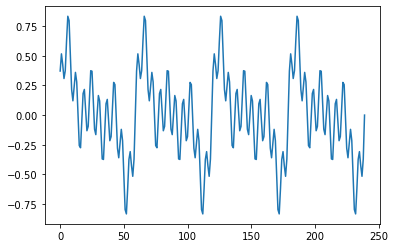

In [3]:
# Dataset configuration
period_len = 60
n_periods = 4
# Generate a distribution of harmonics
harmonics = torch.zeros(period_len//2)
harmonics[1] = 1
harmonics[2] = 1
harmonics[3] = 1
harmonics[10] = 1
# Normalize distribution
harmonics = harmonics/torch.sum(harmonics)

# Create dataset
dataset = HarmonicSeriesDataset(harmonics,n_periods)
dataloader = torch.utils.data.DataLoader(dataset)

# Sample storage to plot
signal_len = len(dataloader)
print(period_len*n_periods)
print(signal_len)
samples = torch.zeros(signal_len)

for i,sample in enumerate(dataloader):
    samples[i] = sample
fig, ax = plt.subplots()
ax.plot(samples.detach().numpy())
plt.show()

# Autoregressive MLP module

In [4]:
class autoregressiveMLP(nn.Module):
    def __init__(self,in_size,seq_len,hidden_layers,hidden_size,device,use_bias = True):
        super().__init__()
        
        total_in_size = in_size * seq_len
        out_size = in_size
        net = []
        if(hidden_layers == 0):
            net.append(nn.Linear(total_in_size,hidden_size,bias=use_bias))
            net.append(nn.ReLU())
            net.append(nn.Linear(hidden_size,out_size,bias=use_bias))
            #net.append(nn.Tanh())
        else:
            net.append(nn.Linear(total_in_size,hidden_size,bias=use_bias))
            net.append(nn.ReLU())
            for i in range(hidden_layers):
                net.append(nn.Linear(hidden_size,hidden_size,bias=use_bias))
                net.append(nn.ReLU())
            net.append(nn.Linear(hidden_size,out_size,bias=use_bias))
            #net.append(nn.Tanh()) # Works better with identity for the toy example
        
        self.net = nn.Sequential(*net)

    '''
    Updates circular buffer with new item and process output
    The model predicts x_n from a collection of previous entries.
    Forward process:
        circular buffer contains all prev samples in this order: 
        [x_{n-1} , x_{n-2}, ... , x_{n-P}]
        1. Predict next output from current collection of prev samples.
        2. Update buffer with either current sample or force the correct value.
        3. Return prediction
    
        I think this is wrong
        # Roll and detach previous grad (otherwise it computes all grads through time)
            self.seq = torch.roll(self.seq,1,0).detach()
            self.seq[0,:] = item
            #print(self.seq.view(-1))
            return self.net(self.seq.view(-1))
    
    '''
    def forward(self,seq):
        ''' 

        '''
        #print("net input: {}".format(self.seq.view(-1)))
        pred = self.net(seq.view(-1))
        return pred

# Training and Evaluation function

In [5]:
def evaluate_on_train_data(net,P,target,device,plot=False):
    target_len = target.size()[0]
    predictions = torch.zeros(target_len)
    seq = torch.zeros([P]).to(device) # Circular buffer to hold previous data
    with torch.no_grad():
        for i, sample in enumerate(target):
            sample = sample.to(device)
            pred = net(seq)
            predictions[i] = pred
            seq = torch.roll(seq,1,0)
            seq[0] = sample # Teacher forcing
            seq.detach()

    eval_loss = torch.sum(torch.abs(target-predictions))
    if(plot):
        fig, ax = plt.subplots()
        print("[TEST ON TRAIN DATA] eval loss {}".format(eval_loss))        
        ax.plot(target.detach().numpy())
        ax.plot(predictions.detach().numpy())
        plt.show()
    return eval_loss
    
def evaluate_dry(net,P,target,device,plot=False):
    target_len = target.size()[0]
    predictions = torch.zeros(target_len)
    seq = torch.zeros([P]).to(device) # Circular buffer to hold previous data
    with torch.no_grad():
        for i in range(target_len):
            predictions[i] = net(seq)
            seq = torch.roll(seq,1,0)
            seq[0] = predictions[i]
            seq.detach()

    eval_loss = torch.sum(torch.abs(target-predictions))
    if(plot):
        fig, ax = plt.subplots()
        print("[DRY TEST] eval loss {}".format(eval_loss))        
        ax.plot(target.detach().cpu().numpy())
        ax.plot(predictions.detach().cpu().numpy())
        plt.show()
    return eval_loss

def evaluate_section(net,P,target,section,device):
    target_len = target.size()[0]
    predictions = torch.zeros(target_len)
    seq = torch.zeros([P]).to(device) # Circular buffer to hold previous data
    l1 = int(target_len*section)
    l2 = target_len - l1
    with torch.no_grad():
        for i in range(l1):
            sample = target[i].to(device)
            predictions[i] = net(seq)
            seq = torch.roll(seq,1,0)
            seq[0] = sample # Teacher forcing
            seq.detach()
        # print("At {}, we have in sequence:".format(section))
        # fig, ax = plt.subplots()
        # ax.plot(seq.detach().cpu().numpy())
        # plt.show()
        # Continue predicting without previous reference
        for i in range(l2):
            predictions[l1 + i] = net(seq)
            seq = torch.roll(seq,1,0)
            seq[0] = predictions[l1 + i] # No teacher forcing
            seq.detach()

    l1_diff = torch.abs(target-predictions)
    eval_loss = torch.sum(l1_diff)
    print("[SECTION TEST] eval loss {}".format(eval_loss))
    fig, ax = plt.subplots()
    ax.plot(target.detach().cpu().numpy())
    ax.plot(predictions.detach().cpu().numpy())
    plt.show()
    # Show error over time
    fig, ax = plt.subplots()
    ax.plot(l1_diff.detach().cpu().numpy())
    ax.plot(predictions.detach().cpu().numpy())
    plt.show()
    
    
def train(net,P,epochs,dataloader,target,device,teacher_force = False):
    net.train()
    criterion = nn.L1Loss()
    optimizer = optim.Adam(net.parameters(), lr=0.001)
    best_eval_loss = np.inf
    #   If I declare the buffer here, then it will have signal present at the
    #   beggining of all epochs except epoch 0. It will be more difficult 
    #   for the model to kickstart its prediction cause it does not overfit 
    #   to the case where it has all zeroes and starts predicting from scratch.
    
    #seq = torch.zeros([P]).to(device)
    
    for epoch in range(epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        seq = torch.zeros([P]).to(device) # Circular buffer to hold previous data        
        for i, sample in enumerate(dataloader):
            sample = sample.to(device)
            optimizer.zero_grad()
            # forward + backward + optimize
            prediction = net(seq)
            seq = torch.roll(seq,1,0)
            seq[0] = sample if teacher_force else prediction
            seq.detach()

            loss = criterion(prediction, sample)
            loss.backward()
            optimizer.step()
            # print statistics
            running_loss += loss.item()


        eval_loss = evaluate_dry(net,P,target,device)
        if eval_loss < best_eval_loss:
            best_eval_loss = eval_loss
            torch.save(net.state_dict(), 'best.pt')
            
        if(epoch % 50 == 0): 
            #fig, ax = plt.subplots()
            #ax.plot(net.seq.detach().numpy())
            #plt.show()
            print("[EPOCH {}] train loss {} - best eval {}".format(epoch,running_loss,best_eval_loss))
            #net.eval()

            #evaluate_on_train_data(net,target)
            
            #net.train()
        running_loss = 0.0

    print('Finished Training')


# Training the MLP

Here, if we don't use `teacher_forcing` then the model does not train.
I believe we may not have to `.detach()` the circular buffer for every new sample we input, this way we would be able to effectively backpropagate through time. Problem is, this constructs very complex gradient trees.

In [6]:
def train_and_test_MLP(P,hidden_size,n_hidden_layers,dataloader,epochs,device,eval_section=0.5):
    #EPOCHS = 400
    # Declare a MLP model
    #seq_length = 100
    #hidden_size = 32
    #n_layers = 3
    samples = torch.zeros(len(dataloader))
    for i,sample in enumerate(dataloader):
        samples[i] = sample

    in_size = 1
    
    net = autoregressiveMLP(in_size,P,n_hidden_layers,hidden_size,device)
    net = net.to(device)
    
    teacher_force = True
    train(net,P,epochs,dataloader,samples,device,teacher_force)
    
    net.load_state_dict(torch.load('best.pt'))
    net.eval()
    evaluate_on_train_data(net,P,samples,device,plot=True)
    
    evaluate_dry(net,P,samples,device,plot=True)
    
    evaluate_section(net,P,samples,eval_section,device)

[EPOCH 0] train loss 57.60204128921032 - best eval 77.01861572265625
[EPOCH 50] train loss 11.635095687583089 - best eval 39.76007080078125
Finished Training
[TEST ON TRAIN DATA] eval loss 11.828112602233887


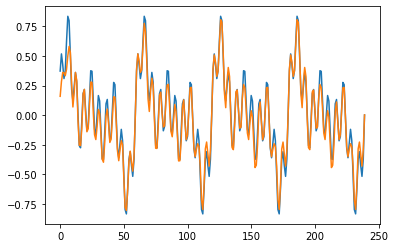

[DRY TEST] eval loss 39.76007080078125


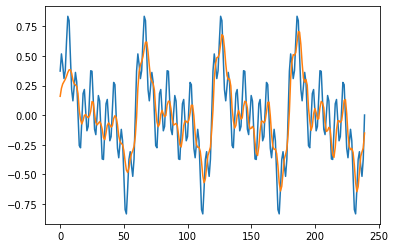

[SECTION TEST] eval loss 13.882784843444824


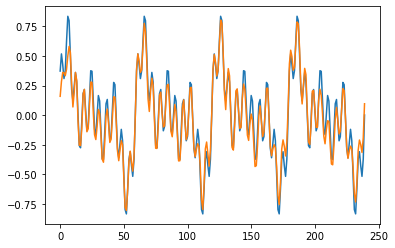

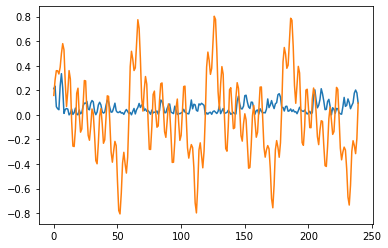

In [7]:
train_and_test_MLP(100,32,3,dataloader,epochs=100,device=dev,eval_section=0.5)


[EPOCH 0] train loss 56.16509643569589 - best eval 74.48799896240234
[EPOCH 50] train loss 12.364897208288312 - best eval 45.65577697753906
Finished Training
[TEST ON TRAIN DATA] eval loss 14.781296730041504


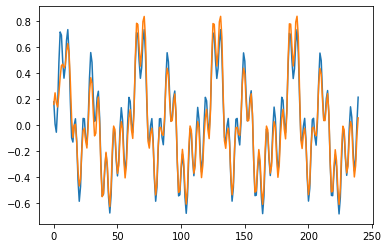

[DRY TEST] eval loss 45.65577697753906


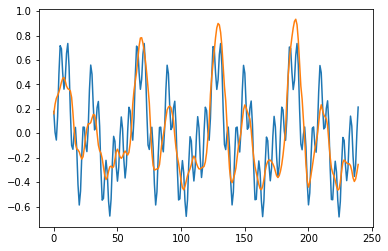

[SECTION TEST] eval loss 20.65433120727539


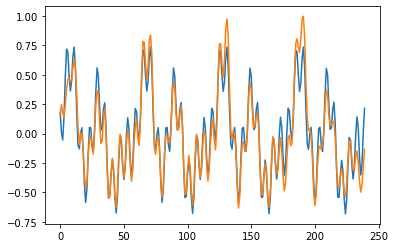

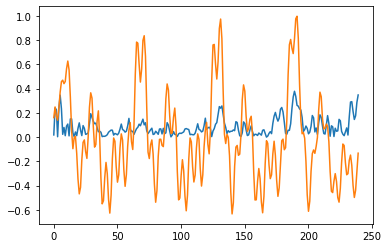

In [8]:
train_and_test_MLP(50,32,3,dataloader,epochs=100,device=dev,eval_section=0.5)

[EPOCH 0] train loss 64.29830478876829 - best eval 81.46037292480469
[EPOCH 50] train loss 11.073911603540182 - best eval 67.76094055175781
Finished Training
[TEST ON TRAIN DATA] eval loss 12.085813522338867


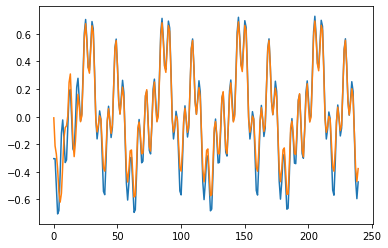

[DRY TEST] eval loss 67.69950866699219


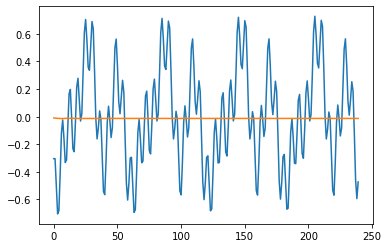

[SECTION TEST] eval loss 59.552616119384766


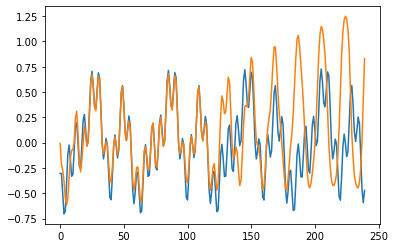

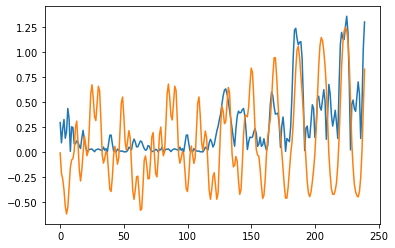

In [9]:
train_and_test_MLP(20,32,3,dataloader,epochs=100,device=dev,eval_section=0.5)

[EPOCH 0] train loss 58.639466267079115 - best eval 82.57929992675781
[EPOCH 50] train loss 12.308003885671496 - best eval 66.68741607666016
Finished Training
[TEST ON TRAIN DATA] eval loss 14.171418190002441


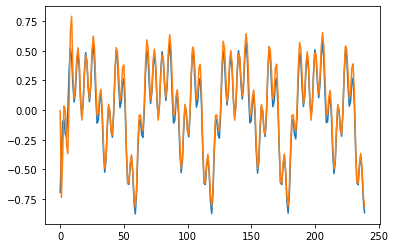

[DRY TEST] eval loss 66.68741607666016


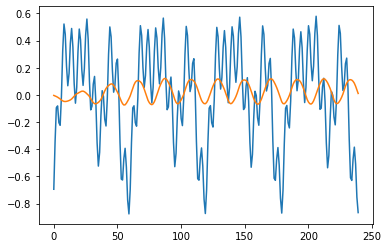

[SECTION TEST] eval loss 4998.37646484375


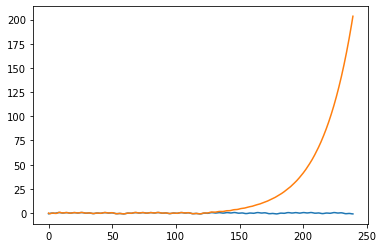

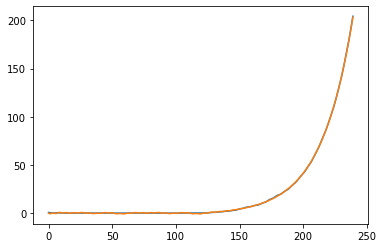

In [10]:
train_and_test_MLP(10,32,3,dataloader,epochs=100,device=dev,eval_section=0.5)

[EPOCH 0] train loss 51.73840203881264 - best eval 182.051025390625
[EPOCH 50] train loss 12.431738572195172 - best eval 66.13729858398438
Finished Training
[TEST ON TRAIN DATA] eval loss 16.34748077392578


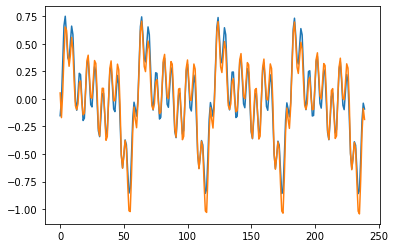

[DRY TEST] eval loss 66.13729858398438


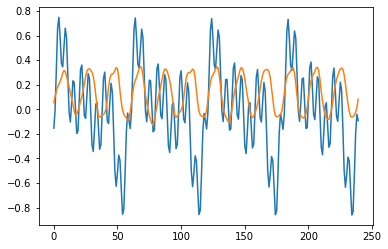

[SECTION TEST] eval loss 39.767662048339844


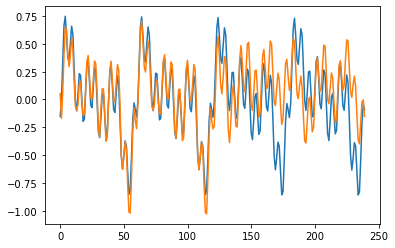

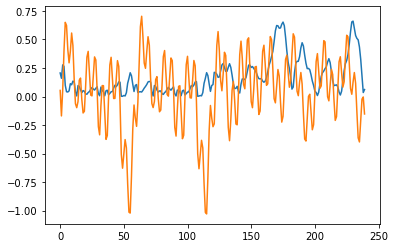

In [11]:
train_and_test_MLP(10,128,3,dataloader,epochs=100,device=dev,eval_section=0.5)

# TCN: Temporal Convolutional Network

## Causal convolution layer
To obtain a causal conv layer, we have to add zero-padding to the left. The amount of padding needed depends of the kernel size $k$ and dilation factor $b$.

\begin{equation}
p = b \cdot (k-1)
\end{equation}

We create a class inheriting from `torch.nn.Conv1d` and apply only left padding to the input.

In [12]:
class CausalConv1d(torch.nn.Conv1d):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride=1,
                 dilation=1,
                 groups=1,
                 bias=True):

        super(CausalConv1d, self).__init__(
            in_channels,
            out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=0,
            dilation=dilation,
            groups=groups,
            bias=bias)
        
        self.__padding = dilation*(kernel_size - 1)
        
    def forward(self, input):
        # Apply left padding using torch.nn.functional and then compute conv.
        return super(CausalConv1d, self).forward(F.pad(input, (self.__padding, 0)))

## TCN Residual Block

A causal convolutional layer will output the same sequence length as the input one. The TCN Residual block also outputs the same length. But, even though we have an output sequence the same size as the input one, this does not guarantee that we will take into account a specific sequence coverage. Therefore, the last question that remains is how to ensure **full sequence coverage**.

Full sequence coverage means that the receptive field is big enough to address the full desired sequence length we have to take into account.

<img src="https://unit8.com/wp-content/uploads/2021/07/image-49.png" width="600">

Image source: https://unit8.com/resources/temporal-convolutional-networks-and-forecasting/

In [18]:
class TCN_block(nn.Module):
    def __init__(self,in_channels,out_channels,kernel_size,stride=1,dilation=1):
        super().__init__()
        block = []
        cnv1 = CausalConv1d(in_channels,out_channels,kernel_size,stride=stride,dilation=dilation)
        block.append(torch.nn.utils.weight_norm( cnv1 ) )
        block.append(nn.ReLU())
        block.append(nn.Dropout())
        
        cnv2 = CausalConv1d(out_channels,out_channels,kernel_size,stride=stride,dilation=dilation)
        block.append(torch.nn.utils.weight_norm( cnv2 ) )
        block.append(nn.ReLU())
        block.append(nn.Dropout())
        self.block = nn.Sequential(*block)
        
        self.residual = nn.Conv1d(in_channels,out_channels,1,padding = 0,stride=stride)
    
    def forward(self,data):
        block_out = self.block(data)
        residual = self.residual(data)
        return block_out + residual

In [14]:
block = TCN_block(1,3,3,stride=1,dilation=2)
b = torch.zeros(100).reshape([1,1,100])

print(block(b).size())

torch.Size([1, 3, 100])


## TCN Network

Given a desired coverage $l$ of the input, a dilation base $b$, and a kernel size base of $k \geq b$, the number of residual block $n$ required to guarantee the coverage is given by:
\begin{equation}
n = log_b(\frac{(l-1)\cdot(b-1)}{(k-1) \cdot 2} + 1)
\end{equation}

In [19]:
class TCN_net(nn.Module):
    def __init__(self,coverage_len,in_channels,hidden_channels,out_channels,kernel_size,dilation_base):
        super().__init__()
        base = 0
        net = []
        arg = ( (coverage_len-1)*(dilation_base-1) )/( (kernel_size-1)*2 ) + 1
        n = int(math.log(arg, dilation_base))
        print("Number of residual connections: {}".format(n))

        net.append(TCN_block(in_channels,hidden_channels,kernel_size,dilation=dilation_base^base))
        if(n>2):
            for i in range(n-2):
                base =+ 1
                net.append(TCN_block(hidden_channels,hidden_channels,kernel_size,dilation=dilation_base^base))
        
        base =+ 1
        net.append(TCN_block(hidden_channels,out_channels,kernel_size,dilation=dilation_base^base))

        self.net = nn.Sequential(*net)
    
    def forward(self,in_sequence):
        return self.net(in_sequence)


In [16]:
net = TCN_net(100,1,64,1,3,2)
print(net)

Number of residual connections: 4
TCN_net(
  (net): Sequential(
    (0): TCN_block(
      (block): Sequential(
        (0): CausalConv1d(1, 64, kernel_size=(3,), stride=(1,), dilation=(2,))
        (1): ReLU()
        (2): Dropout(p=0.5, inplace=False)
        (3): CausalConv1d(64, 64, kernel_size=(3,), stride=(1,), dilation=(2,))
        (4): ReLU()
        (5): Dropout(p=0.5, inplace=False)
      )
      (downsample): Conv1d(1, 64, kernel_size=(1,), stride=(1,))
    )
    (1): TCN_block(
      (block): Sequential(
        (0): CausalConv1d(64, 64, kernel_size=(3,), stride=(1,), dilation=(3,))
        (1): ReLU()
        (2): Dropout(p=0.5, inplace=False)
        (3): CausalConv1d(64, 64, kernel_size=(3,), stride=(1,), dilation=(3,))
        (4): ReLU()
        (5): Dropout(p=0.5, inplace=False)
      )
      (downsample): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
    )
    (2): TCN_block(
      (block): Sequential(
        (0): CausalConv1d(64, 64, kernel_size=(3,), stride=(1,), 

In [17]:
b = torch.zeros(100).reshape([1,1,100])

print(net(b).size())

torch.Size([1, 1, 100])
